In [1]:
import numpy as np
import ast
import scipy   
import matplotlib.pyplot as plt
import cv2     
from keras.applications.resnet50 import ResNet50, preprocess_input
from keras.preprocessing import image    
from keras.models import Model   
from keras.models import load_model
import json, os, re, sys, time

def pretrained_path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    x = np.expand_dims(x, axis=0)
    # convert RGB -> BGR, subtract mean ImageNet pixel, and return 4D tensor
    return preprocess_input(x)

def get_ResNet():
    # define ResNet50 model
#     model = ResNet50(weights='imagenet')
    model_path = 'resnet50_tb_best.h5'
    print('Loading model:', model_path)
    t0 = time.time()
    model = load_model(model_path)
    t1 = time.time()
    print('Loaded in:', t1-t0)
    # get AMP layer weights
    all_amp_layer_weights = model.layers[-1].get_weights()[0]
    # extract wanted output
    ResNet_model = Model(inputs=model.input, 
        outputs=(model.layers[-4].output, model.layers[-1].output)) 
    return ResNet_model, all_amp_layer_weights
    
def ResNet_CAM(img_path, model, all_amp_layer_weights):
    # get filtered images from convolutional output + model prediction vector
    last_conv_output, pred_vec = model.predict(pretrained_path_to_tensor(img_path))
    # change dimensions of last convolutional outpu tto 7 x 7 x 2048
    last_conv_output = np.squeeze(last_conv_output) 
    # get model's prediction (number between 0 and 999, inclusive)
    pred = np.argmax(pred_vec)
    # bilinear upsampling to resize each filtered image to size of original image 
    mat_for_mult = scipy.ndimage.zoom(last_conv_output, (32, 32, 1), order=1) # dim: 224 x 224 x 2048
    # get AMP layer weights
    amp_layer_weights = all_amp_layer_weights[:, pred] # dim: (2048,) 
    # get class activation map for object class that is predicted to be in the image
    final_output = np.dot(mat_for_mult.reshape((224*224, 2048)), amp_layer_weights).reshape(224,224) # dim: 224 x 224
    # return class activation map
    return final_output, pred
    
def plot_ResNet_CAM(img_path, ax, model, all_amp_layer_weights):
    # load image, convert BGR --> RGB, resize image to 224 x 224,
    im = cv2.resize(cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB), (224, 224))
#     im = cv2.imread(img_path)
#     im = cv2.resize(im, (224, 224))
    # plot image
    ax.imshow(im, alpha=0.5)
    # get class activation map
    CAM, pred = ResNet_CAM(img_path, model, all_amp_layer_weights)
    # plot class activation map
    ax.imshow(CAM, cmap='jet', alpha=0.5)
    # load the dictionary that identifies each ImageNet category to an index in the prediction vector
    with open('tb_clsid_to_human.txt') as imagenet_classes_file:
        imagenet_classes_dict = ast.literal_eval(imagenet_classes_file.read())
    # obtain the predicted ImageNet category
    ax.set_title(imagenet_classes_dict[pred])

Using TensorFlow backend.


In [2]:
ResNet_model, all_amp_layer_weights = get_ResNet()

('Loading model:', 'resnet50_tb_best.h5')
('Loaded in:', 7.1362528800964355)


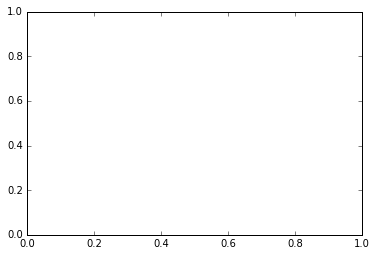

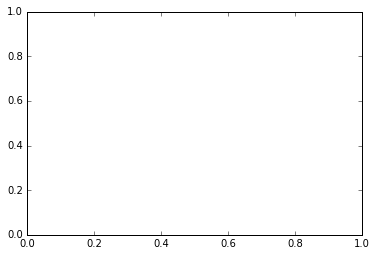

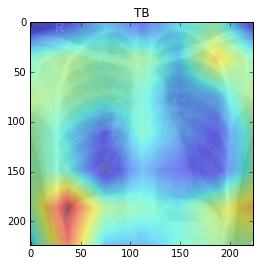

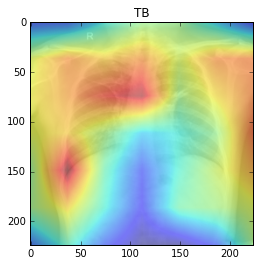

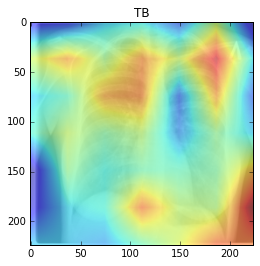

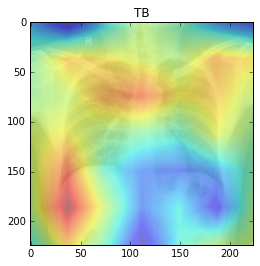

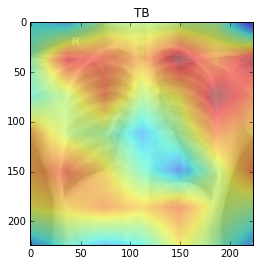

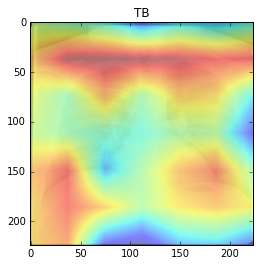

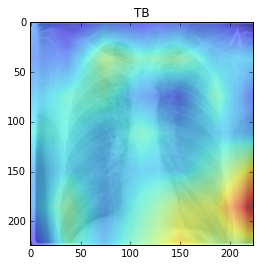

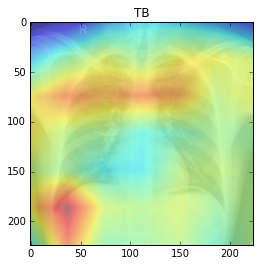

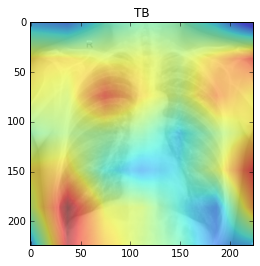

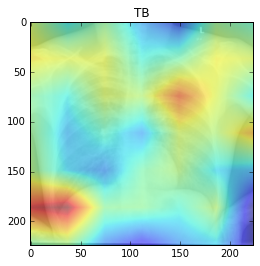

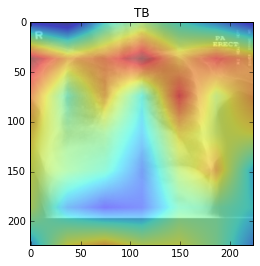

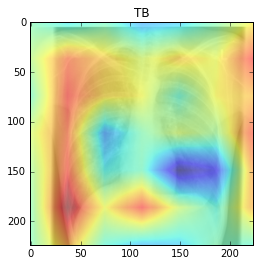

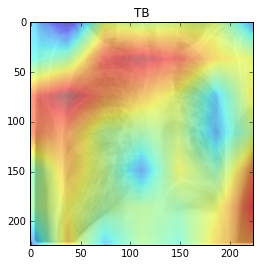

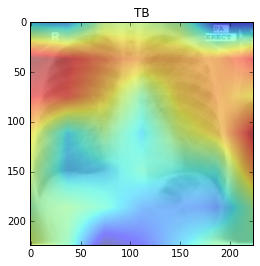

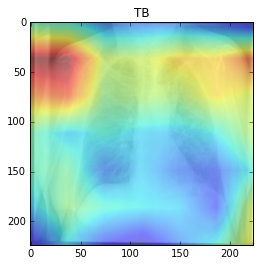

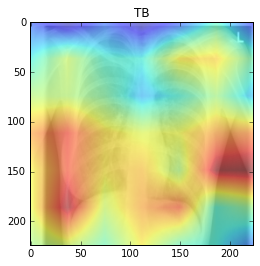

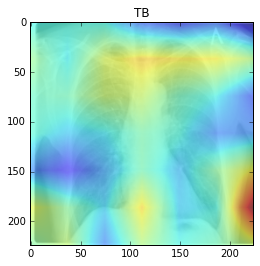

In [ ]:
# img_path = '../testimages/husky.jpg'
# fig, ax = plt.subplots()
# CAM = plot_ResNet_CAM(img_path, ax, ResNet_model, all_amp_layer_weights)
# plt.show()
im_files=["/mnt/data/datasets/tvt1182/chnmcu256test/TB/103.jpg","/mnt/data/datasets/tvt1182/chnmcu256test/TB/107.jpg","/mnt/data/datasets/tvt1182/chnmcu256test/TB/114.jpg"]
im_files = os.listdir('/mnt/data/datasets/tvt1182/chnmcu256test/TB/');
for im_file in im_files:
#     img1 = image.load_img(im_file,target_size=(250,400))
#     img1 = image.img_to_array(img1)
#     img1 = np.expand_dims(img1, axis=0)
#     img1 = preprocess_input(img1)
#     layer_idx = utils.find_layer_idx(model, 'dense_2')
#     heatmap = visualize_cam(model, layer_idx, filter_indices=0, seed_input=img1[0,:,:,:])
#     img_init=utils.load_img(im_file,target_size=(250,400))
#     plt.imshow(overlay(img_init, heatmap))
#     plt.show()
    if im_file.lower().endswith(('.png', '.jpg', '.jpeg')):
            im_file = '/mnt/data/datasets/tvt1182/chnmcu256test/TB/' + im_file
            img_path = im_file
            fig, ax = plt.subplots()
            CAM = plot_ResNet_CAM(img_path, ax, ResNet_model, all_amp_layer_weights)
            plt.show()



In [ ]:
model_path = 'resnet50_tb_best.h5'
model = load_model(model_path)

In [61]:
def predict(img_path, model):
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    preds = model.predict(x)
    return preds

im_files=["/mnt/data/datasets/tvt1182/chnmcu256test/TB/103.jpg","/mnt/data/datasets/tvt1182/chnmcu256test/TB/107.jpg","/mnt/data/datasets/tvt1182/chnmcu256test/TB/114.jpg"]
im_files=["/mnt/data/datasets/tvt1182/chnmcu256test/Normal/203-212-500-500-100.jpg","/mnt/data/datasets/tvt1182/chnmcu256test/Normal/206-215-500-500-100.jpg","/mnt/data/datasets/tvt1182/chnmcu256test/Normal/209-218-500-500-100.jpg"]
# im_files = os.listdir('/mnt/data/datasets/tvt1182/chnmcu256test/TB');
pred_vec =[]
for im_file in im_files:
    pred_vec.append(predict(im_file, model)[0])

print(pred_vec)

[9.9936336e-01 6.3662481e-04]


In [118]:
import numpy
def predict(img_path, model):
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    preds = model.predict(x)
    return preds

im_files=["/mnt/data/datasets/tvt1182/chnmcu256test/TB/103.jpg","/mnt/data/datasets/tvt1182/chnmcu256test/TB/107.jpg","/mnt/data/datasets/tvt1182/chnmcu256test/TB/114.jpg"]
im_files=["/mnt/data/datasets/tvt1182/chnmcu256test/Normal/203-212-500-500-100.jpg","/mnt/data/datasets/tvt1182/chnmcu256test/Normal/206-215-500-500-100.jpg","/mnt/data/datasets/tvt1182/chnmcu256test/Normal/209-218-500-500-100.jpg"]
# im_files = os.listdir('/mnt/data/datasets/tvt1182/chnmcu256test/TB');

a =  np.array([[1, 0]])
# print(a.shape)
# print(pred_vec.shape)
start = True

for im_file in im_files:
    
    pred =predict(im_file, model)
    if(start):
        start = False
        test_Y_notTB = a
        pred_vec_notTB = pred
    else:
        test_Y_notTB = numpy.append(test_Y_notTB, a, axis=0)
        pred_vec_notTB = numpy.append(pred_vec_notTB, pred, axis=0)

print(test_Y_notTB)
print(pred_vec_notTB)
print(classification_report(test_Y_notTB, pred_vec_notTB>0.5, target_names = ['Not TB', 'TB']))

im_files=["/mnt/data/datasets/tvt1182/chnmcu256test/TB/103.jpg","/mnt/data/datasets/tvt1182/chnmcu256test/TB/107.jpg","/mnt/data/datasets/tvt1182/chnmcu256test/TB/114.jpg"]

a =  np.array([[0, 1]])
# print(a.shape)
# print(pred_vec.shape)
start = True
for im_file in im_files:
    
    pred =predict(im_file, model)
    if(start):
        start = False
        test_Y_TB = a
        pred_vec_TB = pred
    else:
        test_Y_TB = numpy.append(test_Y_TB, a, axis=0)
        pred_vec_TB = numpy.append(pred_vec_TB, pred, axis=0)

print(test_Y_TB)
print(pred_vec_TB)
print(classification_report(test_Y_TB, pred_vec_TB>0.5, target_names = ['Not TB', 'TB']))

test_Y = numpy.append(test_Y_notTB, test_Y_TB, axis=0)
pred_vec = numpy.append(pred_vec_notTB, pred_vec_TB, axis=0)

print(test_Y)
print(pred_vec)
print(classification_report(test_Y, pred_vec>0.5, target_names = ['Not TB', 'TB']))

[[1 0]
 [1 0]
 [1 0]]
[[9.9936336e-01 6.3662481e-04]
 [9.9685401e-01 3.1459958e-03]
 [9.8315650e-01 1.6843511e-02]]
             precision    recall  f1-score   support

     Not TB       1.00      1.00      1.00         3
         TB       0.00      0.00      0.00         0

avg / total       1.00      1.00      1.00         3

[[0 1]
 [0 1]
 [0 1]]
[[0.00263731 0.9973627 ]
 [0.00573248 0.9942675 ]
 [0.00131772 0.9986823 ]]
             precision    recall  f1-score   support

     Not TB       0.00      0.00      0.00         0
         TB       1.00      1.00      1.00         3

avg / total       1.00      1.00      1.00         3

[[1 0]
 [1 0]
 [1 0]
 [0 1]
 [0 1]
 [0 1]]
[[9.9936336e-01 6.3662481e-04]
 [9.9685401e-01 3.1459958e-03]
 [9.8315650e-01 1.6843511e-02]
 [2.6373058e-03 9.9736267e-01]
 [5.7324828e-03 9.9426752e-01]
 [1.3177152e-03 9.9868232e-01]]
             precision    recall  f1-score   support

     Not TB       1.00      1.00      1.00         3
         TB       1

In [129]:
import numpy
def predict(img_path, model):
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    preds = model.predict(x)
    return preds

base_dir = '/mnt/data/datasets/tvt/chnmcu256test/'
test_dir = base_dir + 'Normal/'
im_files = os.listdir(test_dir)
# im_files = os.listdir('/mnt/data/datasets/tvt1182/chnmcu256test/TB');

a =  np.array([[1, 0]])
# print(a.shape)
# print(pred_vec.shape)
start = True

print('Normal cases')
for im_file in im_files:
    if im_file.lower().endswith(('.png', '.jpg', '.jpeg')):
        im_file = test_dir + im_file
        pred =predict(im_file, model)
        if(start):
            start = False
            test_Y_notTB = a
            pred_vec_notTB = pred
        else:
            test_Y_notTB = numpy.append(test_Y_notTB, a, axis=0)
            pred_vec_notTB = numpy.append(pred_vec_notTB, pred, axis=0)

# print(test_Y_notTB)
# print(pred_vec_notTB)
print(classification_report(test_Y_notTB, pred_vec_notTB>0.5, target_names = ['Not TB', 'TB']))

test_dir = base_dir + 'TB/'
im_files = os.listdir(test_dir)

print('')
print('TB cases')

a =  np.array([[0, 1]])
# print(a.shape)
# print(pred_vec.shape)
start = True
for im_file in im_files:
    if im_file.lower().endswith(('.png', '.jpg', '.jpeg')):
        im_file = test_dir + im_file
        pred =predict(im_file, model)
        if(start):
            start = False
            test_Y_TB = a
            pred_vec_TB = pred
        else:
            test_Y_TB = numpy.append(test_Y_TB, a, axis=0)
            pred_vec_TB = numpy.append(pred_vec_TB, pred, axis=0)

# print(test_Y_TB)
# print(pred_vec_TB)
print(classification_report(test_Y_TB, pred_vec_TB>0.5, target_names = ['Not TB', 'TB']))

print('')
print('All cases')
test_Y = numpy.append(test_Y_notTB, test_Y_TB, axis=0)
pred_vec = numpy.append(pred_vec_notTB, pred_vec_TB, axis=0)

# print(test_Y)
# print(pred_vec)
print(classification_report(test_Y, pred_vec>0.5, target_names = ['Not TB', 'TB']))

Normal cases
             precision    recall  f1-score   support

     Not TB       1.00      0.90      0.95        50
         TB       0.00      0.00      0.00         0

avg / total       1.00      0.90      0.95        50


TB cases
             precision    recall  f1-score   support

     Not TB       0.00      0.00      0.00         0
         TB       1.00      0.84      0.91        50

avg / total       1.00      0.84      0.91        50


All cases
             precision    recall  f1-score   support

     Not TB       0.85      0.90      0.87        50
         TB       0.89      0.84      0.87        50

avg / total       0.87      0.87      0.87       100

